In [111]:
# library dependencies
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import lzma
import pickle
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import tensorflow as tf

In [2]:
# method to store data as serialized binary structure lzma compressed
def can_pickles(data, filename):
    with lzma.LZMAFile(filename, 'wb') as f:
        pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# method to retrieve data from a compressed pickle file (created with the method above)
def uncan_pickles(filename):
    with lzma.LZMAFile(filename, 'rb') as f:
        return pickle.load(f)

baseline data

X holds a list of sequences one hot encoded
y holds a list of PTR values as floats

In [127]:
# read the prepared data back
X = uncan_pickles('../data/onehot_x_lung.pickle.xz')
y = uncan_pickles('../data/onehot_y_lung.pickle.xz')

In [128]:
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, padding="post")

In [129]:
# convert type of target values from string to float
y = np.array(y).astype(float)

In [131]:
X[0]

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [132]:
y[0]

7.544

In [133]:
# count of input sequences
len(X)

8201

split data in train and test subsets

verify that the split worked properly

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=1202)

In [134]:
# get a sample
X_train[1]

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

In [135]:
# get the matching target
y_train[1]

3.746

In [136]:
# find the target value in the raw dataset
for i in range(len(y)):
    if y[i] == 3.746:
        print(i)

6663


In [138]:
# compare if the raw dataset entry matches the subset entry
if X_padded[6663].all() == X_train[1].all():
    print('OK')

OK


model building

In [147]:
def baseline_model():
    # input
    inputs = layers.Input(shape=(None, 4), name='SequenceInput')
    # 1D convolution
    conv = layers.Conv1D(
        filters=128, 
        kernel_size=10, 
        strides=1, 
        activation='relu',
        name='Conv1D'
    )(inputs)
    # batch normalization
    norm = layers.BatchNormalization(name='Normalization1')(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=4,
        strides=4,
        name='Pooling'
    )(norm)
    # dropout
    drop = layers.Dropout(rate=0.2, name='Dropout1')(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=128, 
            dropout=0
        ),
        merge_mode='sum',
        input_shape=(None, 4),
        name='BiDirectionalLSTM'
    )(drop)
    drop = layers.Dropout(rate=0.2, name='Dropout2')(bilstm)
    # flatten
    flat = layers.Flatten()(drop)
    # fully connected
    dense = layers.Dense(
        units=64,
        activation='relu',
        name='FullyConnected'
    )(flat)
    # batch normalization
    norm = layers.BatchNormalization(name='Normalization2')(dense)
    # dropout
    drop = layers.Dropout(rate=0.2, name='Dropout3')(norm)
    # dense
    outputs = layers.Dense(units=1, name='Output')(drop)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='BaselineModel')
    
    return model

In [153]:
model = baseline_model()

In [154]:
model.summary()

Model: "BaselineModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SequenceInput (InputLayer)  [(None, None, 4)]         0         
                                                                 
 Conv1D (Conv1D)             (None, None, 128)         5248      
                                                                 
 Normalization1 (BatchNorma  (None, None, 128)         512       
 lization)                                                       
                                                                 
 Pooling (MaxPooling1D)      (None, None, 128)         0         
                                                                 
 Dropout1 (Dropout)          (None, None, 128)         0         
                                                                 
 BiDirectionalLSTM (Bidirec  (None, 128)               263168    
 tional)                                             

In [106]:
keras.utils.plot_model(model, 'baseline.png')
# img = plt.imread('baseline.png')
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [170]:
model.compile(
    loss=keras.losses.LogCosh(),
    optimizer=keras.optimizers.RMSprop(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(), keras.metrics.RootMeanSquaredError(), keras.losses.MeanSquaredError(), keras.metrics.MeanAbsoluteError(), keras.metrics.LogCoshError()],
)

# LOSS
# works keras.losses.MeanSquaredError(),

# METRIC
# useless keras.metrics.Accuracy(), 

In [117]:
# alternative methode to prepadding the sequences
# X_train_ragged = tf.ragged.constant(X_train, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
# dataset = tf.data.Dataset.from_tensor_slices(tensor)
# dataset = dataset.map(lambda x: x)

In [171]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
82/82 [==============================] - 80s 961ms/step - loss: 0.1947 - mean_absolute_percentage_error: 11.5574 - root_mean_squared_error: 0.6817 - mean_squared_error: 0.4647 - mean_absolute_error: 0.5359 - logcosh: 0.1947 - val_loss: 0.3921 - val_mean_absolute_percentage_error: 18.9036 - val_root_mean_squared_error: 1.0449 - val_mean_squared_error: 1.0943 - val_mean_absolute_error: 0.8106 - val_logcosh: 0.3921
Epoch 2/100
82/82 [==============================] - 78s 946ms/step - loss: 0.1878 - mean_absolute_percentage_error: 11.3679 - root_mean_squared_error: 0.6670 - mean_squared_error: 0.4449 - mean_absolute_error: 0.5280 - logcosh: 0.1878 - val_loss: 0.3620 - val_mean_absolute_percentage_error: 17.2009 - val_root_mean_squared_error: 0.9873 - val_mean_squared_error: 0.9761 - val_mean_absolute_error: 0.7788 - val_logcosh: 0.3620
Epoch 3/100
82/82 [==============================] - 78s 952ms/step - loss: 0.1827 - mean_absolute_percentage_error: 11.1356 - root_mean_squared

In [172]:
y_pred = model.predict(X_test)

52/52 [==============================] - 8s 148ms/step


In [173]:
print(y_test[0], y_pred[0])

4.92 [5.284849]


In [174]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'root_mean_squared_error', 'mean_squared_error', 'mean_absolute_error', 'logcosh', 'val_loss', 'val_mean_absolute_percentage_error', 'val_root_mean_squared_error', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_logcosh'])

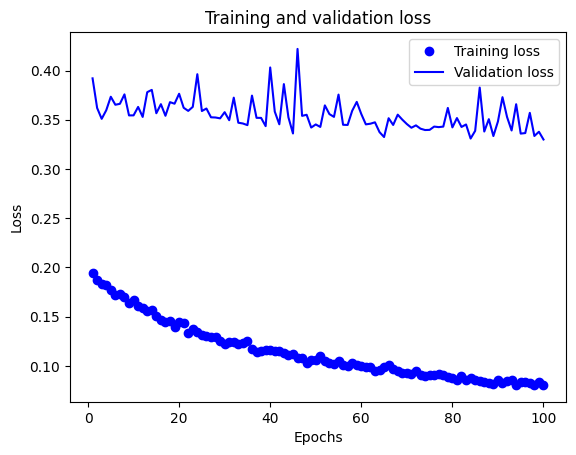

In [175]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [50]:
def full_model():
    # input
    inputs = keras.Input(shape=(None, 10))
    # 1D convolution
    conv = keras.Conv1D(
        filters=128, 
        kernel_size=10, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = keras.BatchNormalization()(conv)
    # maxpool
    pool = keras.MaxPooling1D(
        pool_size=4,
        strides=4
    )(norm)
    # dropout
    drop = keras.Dropout(rate=0.2)(pool)
    # bi-directional LSTM
    bilstm = keras.Bidirectional(
        keras.LSTM(
            units=128,
            dropout=0
        ),
        merge_mode='concat'
    )(drop)
    # batch normalization
    norm = keras.BatchNormalization()(bilstm)
    # maxpool
    pool = keras.MaxPooling1D(
        pool_size=4,
        strides=4
    )(norm)
    # dropout
    drop = keras.Dropout(rate=0.2)(pool)
    # flatten
    flat = keras.Flatten()(drop)

    # second input
    inputs2 = keras.Input(shape=(29,))

    # concatenation
    conc = keras.Concatenate(axis=1)([inputs, inputs2])

    # fully connected
    dense = keras.Dense(
        units=64,
        activation='relu'
    )(conc)
    # batch normalization
    norm = keras.BatchNormalization()(dense)
    # dropout
    drop = keras.Dropout(rate=0.2)(norm)
    # dense
    outputs = keras.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=[inputs, inputs2], outputs=outputs, name='full_model')
    
    return model